In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

import plotly.express as px

# Обзор данных

**Описания признаков:**
* imdb_id - идентификатор 
* budget - бюджет 
* revenue - сборы 
* original_title - оригинальное название
* cast - актёры
* director - режиссёр
* tagline - слоган 
* overview - описание 
* runtime - продолжительность
* genres - жанры
* production_companies - производственные компании
* release_date - дата релиза
* vote_average - средний рейтинг
* release_year - год производства

In [5]:
data = pd.read_csv('movie_bd_v5.csv')
data.sample(5)

,imdb_id,budget,revenue,original_title,cast,director,tagline,overview,runtime,genres,production_companies,release_date,vote_average,release_year
340,tt1311067,15000000,39421467,Halloween II,Scout Taylor-Compton|Sheri Moon Zombie|Tyler M...,Rob Zombie,Family Is Forever,Laurie Strode struggles to come to terms with ...,105,Horror,Dimension Films|Spectacle Entertainment Group|...,8/28/2009,5.2,2009
803,tt1598822,56000000,142044638,New Year's Eve,Robert De Niro|Katherine Heigl|Ashton Kutcher|...,Garry Marshall,The one night anything is possible.,The lives of several couples and singles in Ne...,118,Comedy|Romance,New Line Cinema,12/8/2011,5.6,2011
1798,tt0499554,10000000,20342161,Reno 911!: Miami,Lennie Loftin|Danny DeVito|Ben Garant|Carlos A...,Ben Garant,"In a time of crisis, America will call Reno 911!",A rag-tag team of Reno cops are called in to s...,84,Action|Adventure|Comedy|Crime,20th Century Fox,2/23/2007,5.8,2007
405,tt1037705,80000000,157107755,The Book of Eli,Denzel Washington|Gary Oldman|Michael Gambon|M...,Albert Hughes|Allen Hughes,Some will kill to have it. He will kill to pro...,"A post-apocalyptic tale, in which a lone man f...",118,Action|Thriller|Science Fiction,Alcon Entertainment|Silver Pictures,1/14/2010,6.5,2010
98,tt3369806,20000000,43967255,Max,Thomas Haden Church|Josh Wiggins|Lauren Graham...,Boaz Yakin,Best Friend. Hero. Marine.,A dog that helped soldiers in Afghanistan retu...,111,Adventure|Drama|Family,Sunswept Entertainment|Warner Bros.|Metro-Gold...,6/26/2015,7.0,2015


In [6]:
data.info()  # Проверяем, есть ли пропуски в данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   imdb_id               1889 non-null   object 
 1   budget                1889 non-null   int64  
 2   revenue               1889 non-null   int64  
 3   original_title        1889 non-null   object 
 4   cast                  1889 non-null   object 
 5   director              1889 non-null   object 
 6   tagline               1889 non-null   object 
 7   overview              1889 non-null   object 
 8   runtime               1889 non-null   int64  
 9   genres                1889 non-null   object 
 10  production_companies  1889 non-null   object 
 11  release_date          1889 non-null   object 
 12  vote_average          1889 non-null   float64
 13  release_year          1889 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 206.7+ KB


Пропусков нет. Данные представлены разных типов. С некоторыми признаками надо будет "поработать", чтобы вытащить необходимую информацию для ответа на вопросы (cast, genres, production_companies, release_date)

# Предобработка

In [7]:
answers = {}  # создадим словарь для ответов

data['profit'] = data['revenue'] - data['budget']  # Добавление колонки с прибылью
data['len_title'] = data['original_title'].apply(lambda x: len(x))  # Добавление колонки с длиной названия фильма

# Разделение данных в колонках с несколькими строковыми значениями для дальнейшей работы
data['genres'] = data['genres'].str.split('|')
data['cast'] = data['cast'].str.split('|')
data['director'] = data['director'].str.split('|')
data['production_companies'] = data['production_companies'].str.split('|')
# Добавление колоки с количеством слов в описании
data['words_in_overview'] = data['overview'].apply(lambda x: len(x.split(' '))) 


def month(x):
    """Функция для преобразования номера месяца (из типа str) в название месяца"""
    if x == '1':
        return 'January'
    elif x == '2':
        return 'February'
    elif x == '3':
        return 'March'
    elif x == '4':
        return 'April'
    elif x == '5':
        return 'May'
    elif x == '6':
        return 'June'
    elif x == '7':
        return 'July'
    elif x == '8':
        return 'August'
    elif x == '9':
        return 'September'
    elif x == '10':
        return 'October'
    elif x == '11':
        return 'November'
    else:
        return 'December'


data['month'] = data['release_date'].str.split(
    '/').apply(lambda x: month(x[0]))  # Добавление колонки с названием месяца

# Вопросы и ответы на них

## 1. У какого фильма из списка самый большой бюджет?

In [8]:
print('Фильм, с самым большим бюджетом: {} / {} $'.format(
    (data[data['budget'] == data['budget'].max()]['original_title'].iloc[0]),
    (data[data['budget'] == data['budget'].max()]['budget'].iloc[0])))

Фильм, с самым большим бюджетом: Pirates of the Caribbean: On Stranger Tides / 380000000 $


In [9]:
answers['1'] = data[data['budget'] == data['budget'].max()]['original_title'].iloc[0]  # Добавляем ответ в словарь

## 2. Какой из фильмов самый длительный (в минутах)?

In [10]:
print('Самый длительный фильм: {} / {} мин.'.format(
    (data[data['runtime'] == data['runtime'].max()]['original_title'].iloc[0]),
    (data[data['runtime'] == data['runtime'].max()]['runtime'].iloc[0])))

Самый длительный фильм: Gods and Generals / 214 мин.


In [11]:
answers['2'] = data[data['runtime'] == data['runtime'].max()]['original_title'].iloc[0] 

## 3. Какой из фильмов самый короткий (в минутах)?

In [12]:
print('Самый короткий фильм: {} / {} мин.'.format(
    (data[data['runtime'] == data['runtime'].min()]['original_title'].iloc[0]),
    (data[data['runtime'] == data['runtime'].min()]['runtime'].iloc[0])))

Самый короткий фильм: Winnie the Pooh / 63 мин.


In [13]:
answers['3'] = data[data['runtime'] == data['runtime'].min()]['original_title'].iloc[0]

## 4. Какова средняя длительность фильмов?

In [14]:
print('Средняя продолжительность фильмов : {:.2f} мин.'. format(data['runtime'].mean()))

Средняя продолжительность фильмов : 109.66 мин.


In [15]:
answers['4'] = data['runtime'].mean() 

## 5. Каково медианное значение длительности фильмов? 

In [16]:
print('Медианное значение длительности фильмов : {} мин.'.format(data['runtime'].median()))

Медианное значение длительности фильмов : 107.0 мин.


In [17]:
answers['5'] = data['runtime'].median() 

## 6. Какой самый прибыльный фильм?
#### Внимание! Здесь и далее под «прибылью» или «убытками» понимается разность между сборами и бюджетом фильма. (прибыль = сборы - бюджет) в нашем датасете это будет (profit = revenue - budget) 

In [18]:
print('Самый прибыльный фильм: {} / {} $'.format(
    (data[data['profit'] == data['profit'].max()]['original_title'].iloc[0]),
    (data[data['profit'] == data['profit'].max()]['profit'].iloc[0])))

Самый прибыльный фильм: Avatar / 2544505847 $


In [19]:
answers['6'] = data[data['profit'] == data['profit'].max()]['original_title'].iloc[0]

## 7. Какой фильм самый убыточный? 

In [20]:
print('Самый убыточный фильм: {} / {} $'.format(
    (data[data['profit'] == data['profit'].min()]['original_title'].iloc[0]),
    (data[data['profit'] == data['profit'].min()]['profit'].iloc[0])))

Самый убыточный фильм: The Lone Ranger / -165710090 $


In [21]:
answers['7'] = data[data['profit'] == data['profit'].min()]['original_title'].iloc[0]

## 8. У скольких фильмов из датасета объем сборов оказался выше бюджета?

In [22]:
print("Прибыльных фильмов: {} штук | {:.2%} от всех фильмов в датасете".format(
    len(data[data['profit'] > 0]), ((len(data[data['profit'] > 0]) / len(data)))))

Прибыльных фильмов: 1478 штук | 78.24% от всех фильмов в датасете


In [23]:
answers['8'] = len(data[data['profit'] > 0])  

## 9. Какой фильм оказался самым кассовым в 2008 году?

In [24]:
data_2008 = data[data['release_year'] == 2008]
print('Самый прибыльный фильм в 2008 году: {} / {} $'.format(
    (data_2008[data_2008['profit'] == data_2008['profit'].max()]['original_title'].iloc[0]),
    (data_2008[data_2008['profit'] == data_2008['profit'].max()]['profit'].iloc[0])))

Самый прибыльный фильм в 2008 году: The Dark Knight / 816921825 $


In [25]:
answers['9'] = data_2008[data_2008['profit'] == data_2008['profit'].max()]['original_title'].iloc[0]

## 10. Самый убыточный фильм за период с 2012 по 2014 г. (включительно)?


In [26]:
data_201222014 = data[((data['release_year'] >= 2012) &
                       (data['release_year'] <= 2014))]
print('Самый убыточный фильм в 2012-2014 году: {} / {} $'.format(
    (data_201222014[data_201222014['profit'] ==
                    data_201222014['profit'].min()]['original_title'].iloc[0]),
    (data_201222014[data_201222014['profit'] == data_201222014['profit'].min()]['profit'].iloc[0])))

Самый убыточный фильм в 2012-2014 году: The Lone Ranger / -165710090 $


In [27]:
answers['10'] = data_201222014[data_201222014['profit'] ==
                               data_201222014['profit'].min()]['original_title'].iloc[0]

## 11. Какого жанра фильмов больше всего?

Размер нового датасета: (5107, 18)


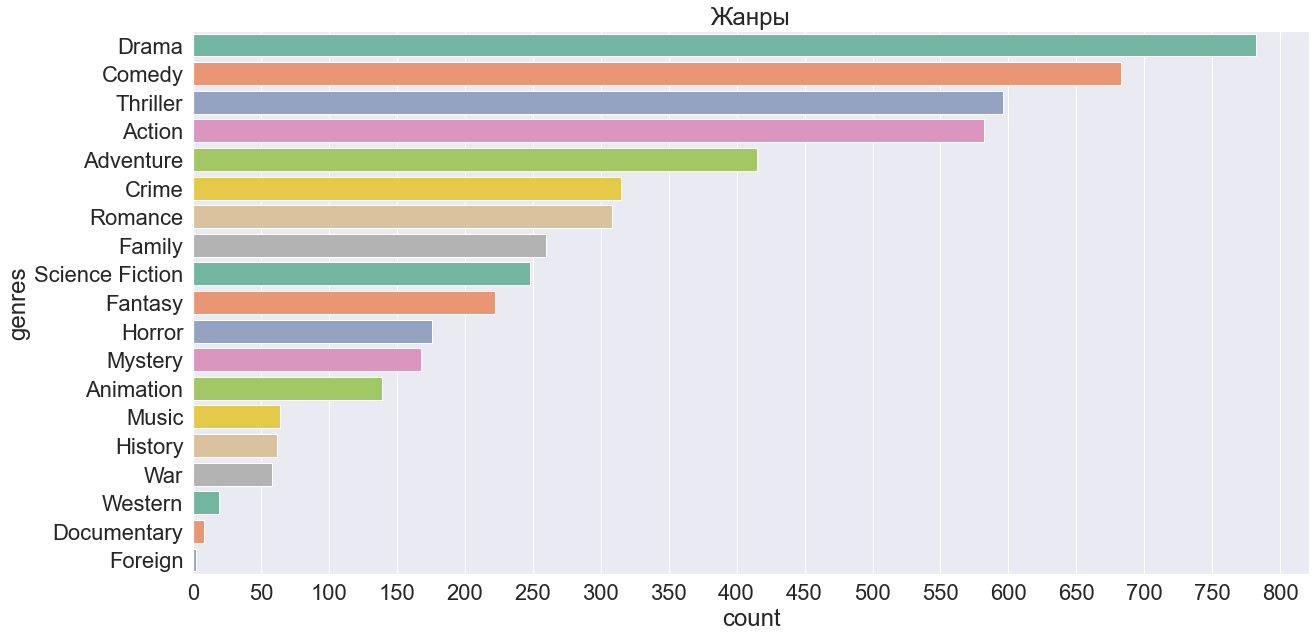

In [28]:
# Новый датасет, где в каждой строке в колонке genres только один жанр
data_genres = data.explode('genres')
print("Размер нового датасета: {}".format(data_genres.shape))

# Количество фильмов каждого жанра
sns.set(font_scale=2)
plt.subplots(figsize=(20, 10))
plt.xticks(ticks = range(0,801,50))
plt.title('Жанры')
sns.countplot(y="genres",
              data=data_genres,
              order=data_genres.genres.value_counts().index,
              palette='Set2')

In [ ]:
px.

In [32]:
answers['11'] = data_genres['genres'].value_counts().index[0] 

## 12. Фильмы какого жанра чаще всего становятся прибыльными? 

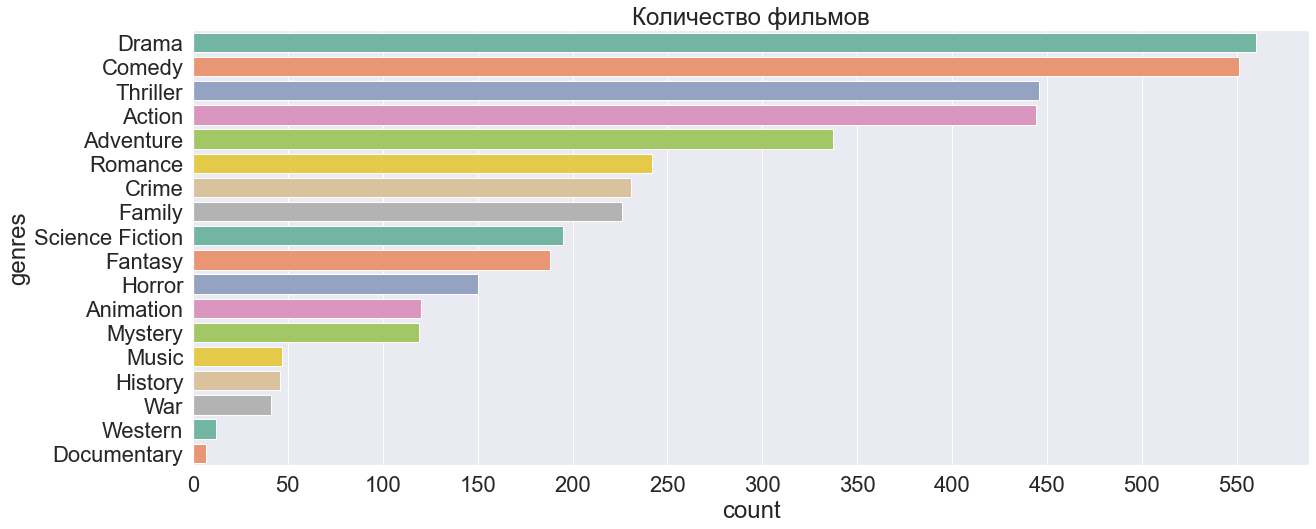

In [185]:
# Количество прибыльных фильмов каждого жанра
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks = range(0,601,50))
plt.title('Количество фильмов')
sns.countplot(y="genres",  
              data=data_genres[data_genres['profit'] > 0],
              order=data_genres[data_genres['profit'] > 0].genres.value_counts().index, 
              palette='Set2')

In [93]:
answers['12'] = data_genres[data_genres['profit'] > 0]['genres'].value_counts().index[0]

## 13. У какого режиссера самые большие суммарные кассовые сборы?

In [38]:
fig = px.bar(data_director, 
             x=(data_director.groupby(['director']).revenue.sum().sort_values(ascending=False).values)/1000000000, 
             y=data_director.groupby(['director']).revenue.sum().sort_values(ascending=False).index)

fig.show()

Размер нового датасета: (2053, 18)


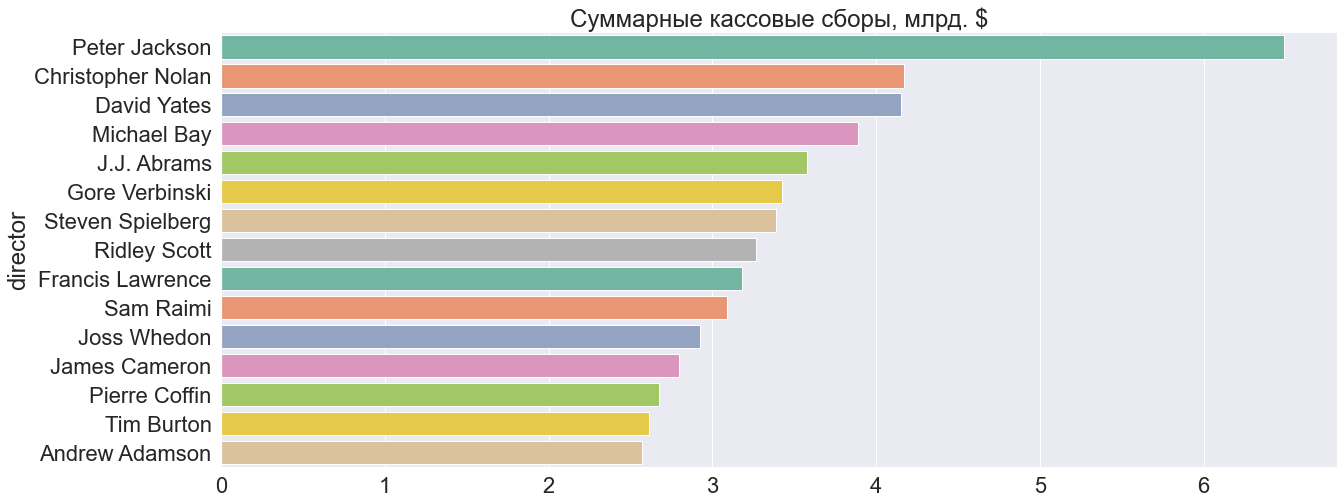

In [29]:
# Новый датасет, где в каждой строке в колонке director только один режиссер
data_director = data.explode('director') 
print("Размер нового датасета: {}".format(data_director.shape))

# Построим график для первых 15-ти режиссеров по кассовым сборам
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Суммарные кассовые сборы, млрд. $')
sns.color_palette("Set2")
sns.barplot(x=(data_director.groupby(['director']).revenue.sum().sort_values(ascending=False)[:15].values)/1000000000,
            y=data_director.groupby(['director']).revenue.sum().sort_values(ascending=False)[:15].index,
            palette='Set2', 
            orient='h')

In [186]:
data_director.groupby(['director']).revenue.sum().sort_values(ascending=False)

director
Peter Jackson        6490593685
Christopher Nolan    4167548502
David Yates          4154295625
Michael Bay          3886938960
J.J. Abrams          3579169916
                        ...    
David MichÃ´d           2295423
Steven Shainberg        2281089
Paul Schrader           2062066
Keanu Reeves            2054941
Simon Hunter            2033165
Name: revenue, Length: 997, dtype: int64

In [30]:
answers['13'] = data_director.groupby(['director']).revenue.sum().idxmax() 

## 14. Какой режисер снял больше всего фильмов в стиле Action?

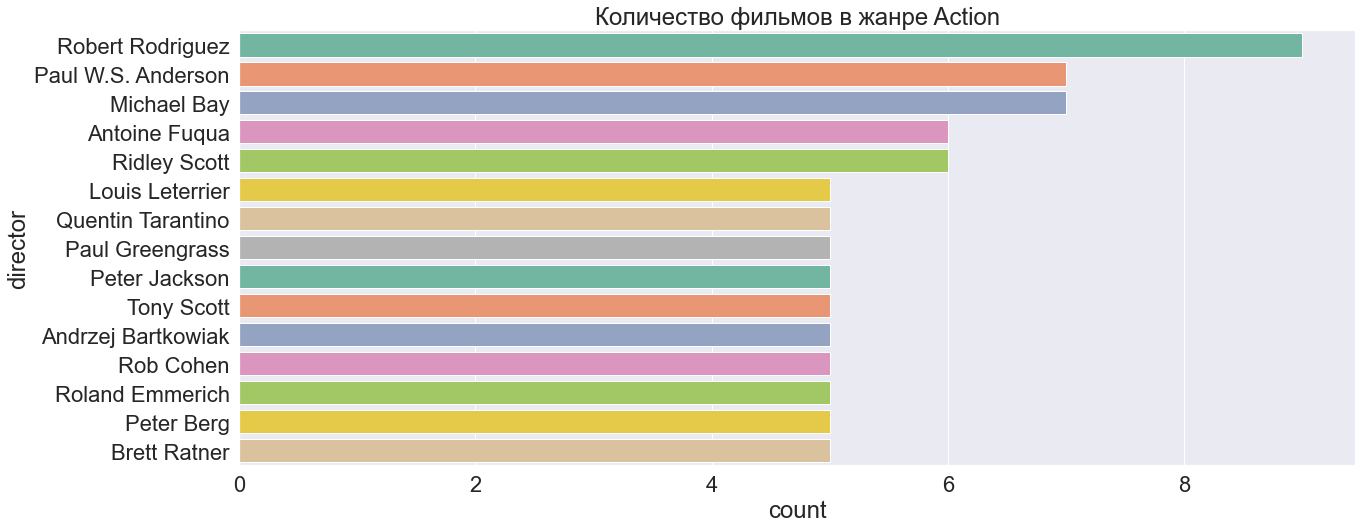

In [150]:
data_action = data_genres[data_genres['genres'] == 'Action']
data_act_dir = data_action.explode('director')
data_act_dir['director'].value_counts()


# Построим график для первых 15-ти режиссеров по количеству
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Количество фильмов в жанре Action')
sns.countplot(y="director", 
              data=data_act_dir,
              order=data_act_dir.director.value_counts()[:15].index,
              palette='Set2')

In [32]:
answers['14'] = data_act_dir['director'].value_counts().index[0]  

## 15. Фильмы с каким актером принесли самые высокие кассовые сборы в 2012 году? 

Размер нового датасета: (555, 18)


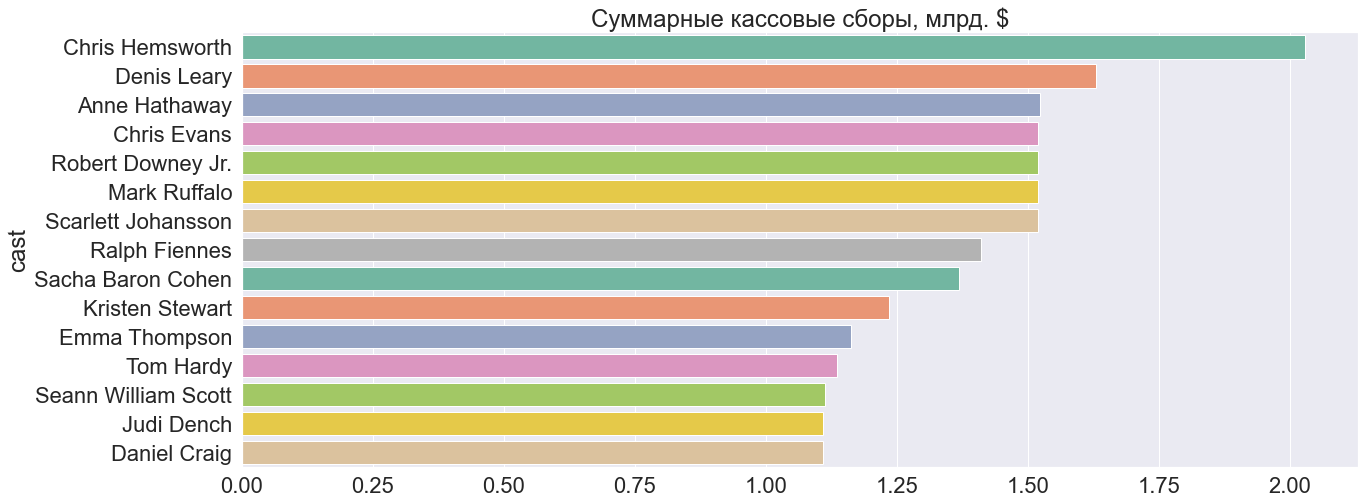

In [201]:
data_2012 = data[data.release_year == 2012].copy()
data_cast2012 = data_2012.explode('cast')
print("Размер нового датасета: {}".format(data_cast2012.shape))

# Построим график для первых 15-ти актёров по кассовым сборам
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.title('Суммарные кассовые сборы, млрд. $')
sns.color_palette("Set2")
sns.barplot(x=data_cast2012.groupby(['cast']).revenue.sum().sort_values(ascending=False)[:15].values/1000000000,
            y=data_cast2012.groupby(['cast']).revenue.sum().sort_values(ascending=False)[:15].index,
            palette='Set2', 
            orient='h')

In [34]:
answers['15'] = data_cast2012.groupby(['cast']).revenue.sum().idxmax()  # "+"

## 16. Какой актер снялся в большем количестве высокобюджетных фильмов?

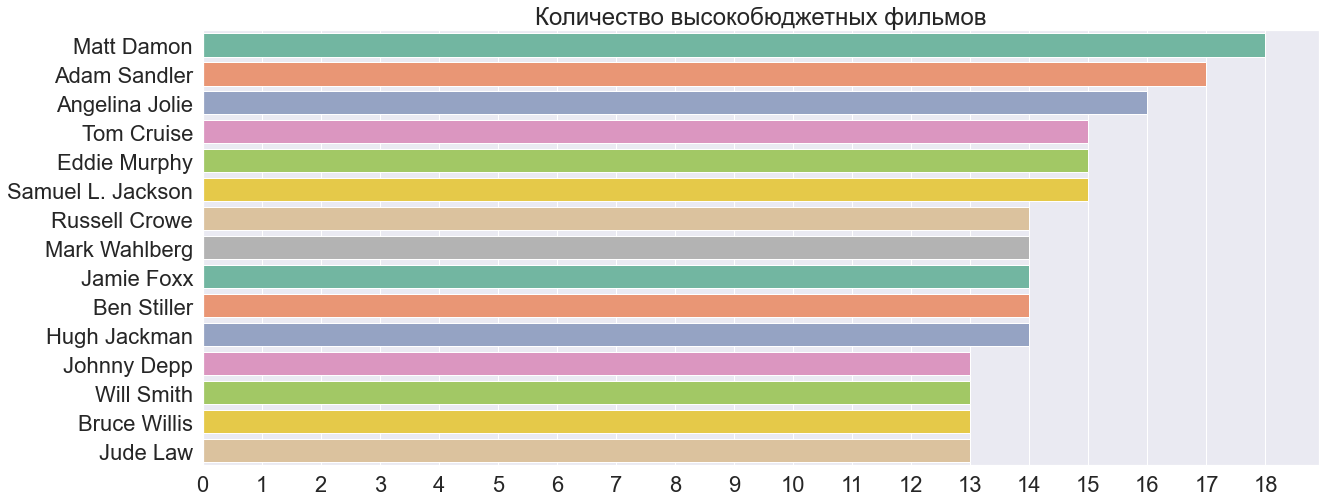

In [167]:
data_mome = data[data['budget'] > data['budget'].mean()]  # высокобюджетные - бюджет выше среднего
data_cast_mome = data_mome.explode('cast')
data_cast_mome['cast'].value_counts()

# Построим график для первых 15-ти актёров по cъемках в высокобюджетных фильмах
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks = range(0,20))
plt.title('Количество высокобюджетных фильмов')
sns.color_palette("Set2")
sns.barplot(x=data_cast_mome['cast'].value_counts()[:15].values,
            y=data_cast_mome['cast'].value_counts()[:15].index,
            palette='Set2',
            orient='h')

In [36]:
answers['16'] = data_cast_mome['cast'].value_counts().index[0] 

## 17. В фильмах какого жанра больше всего снимался Nicolas Cage? 

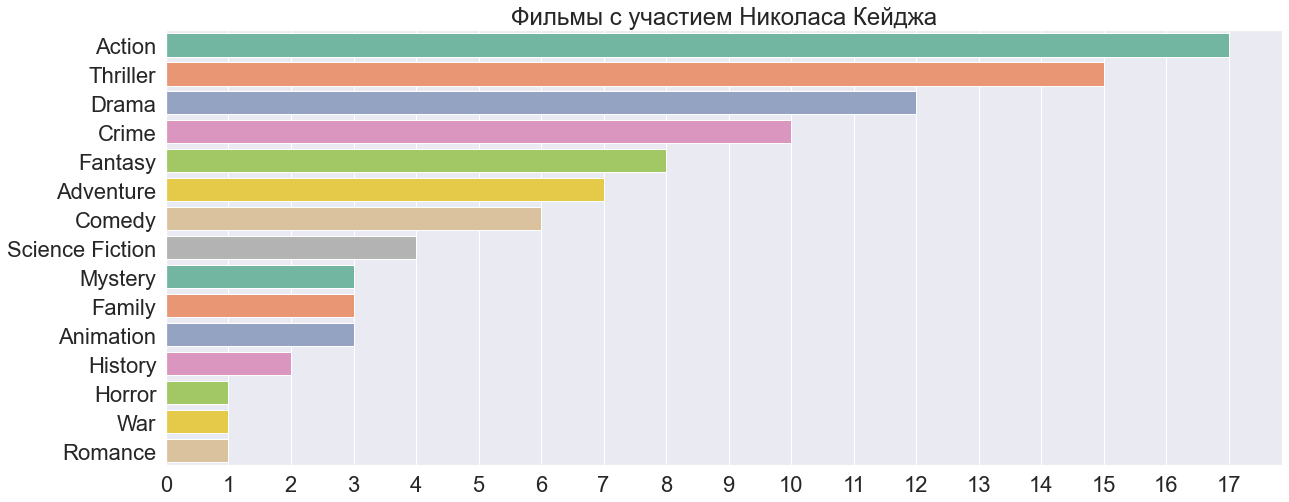

In [204]:
data_cast = data.explode('cast')
data_Cage = data_cast[data_cast['cast'] == 'Nicolas Cage']
data_genres_Cage = data_Cage.explode('genres')
data_genres_Cage['genres'].value_counts()

# Количество фильмов каждого жанра
sns.set(font_scale=2)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks = range(0,20,1))
plt.title('Фильмы с участием Николаса Кейджа')
sns.color_palette("Set2")
sns.barplot(x=data_genres_Cage['genres'].value_counts().values,
            y=data_genres_Cage['genres'].value_counts().index,
            palette='Set2', 
            orient='h')

In [38]:
answers['17'] = data_genres_Cage['genres'].value_counts().index[0] 

## 18. Самый убыточный фильм от Paramount Pictures

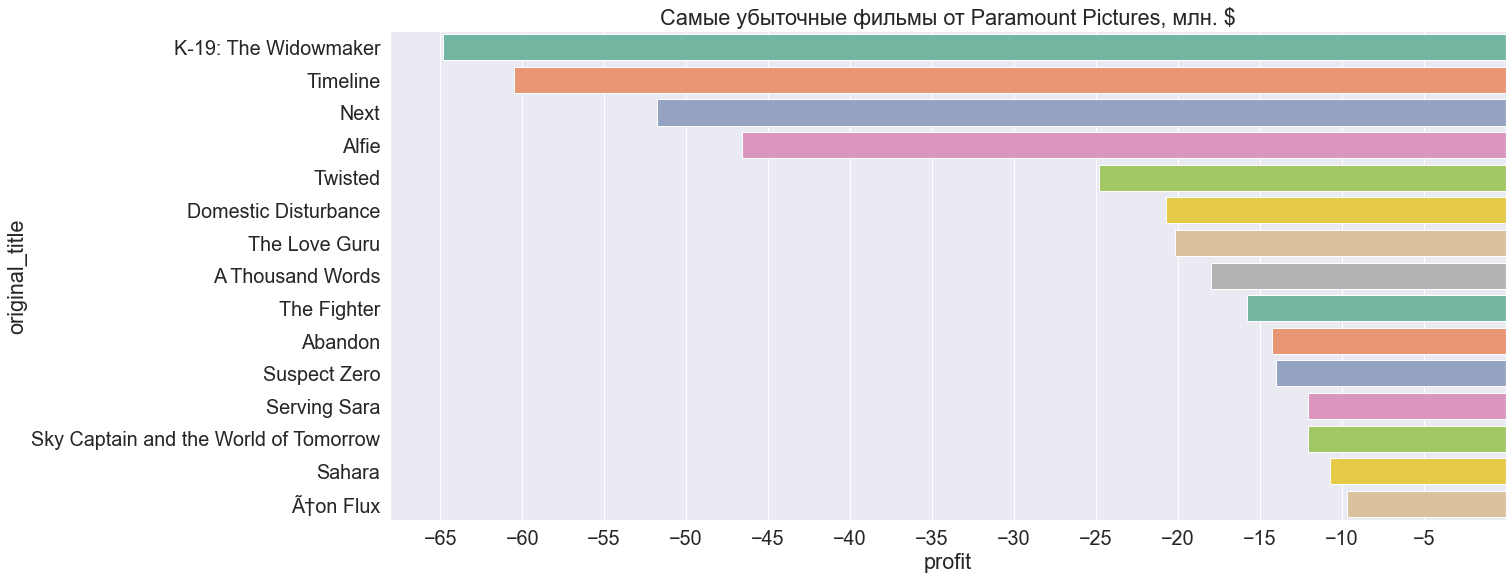

In [222]:
data_companies = data.explode('production_companies')
data_Paramount = data_companies[data_companies['production_companies'] == 'Paramount Pictures']
data_Paramount[['original_title', 'profit']].sort_values(['profit'])['original_title']

# Построим графикх 15-ти самых убыточных фильмов от Paramount Pictures
sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 9))
plt.xticks(ticks = range(-70,0,5))
plt.title('Самые убыточные фильмы от Paramount Pictures, млн. $')
sns.color_palette("Set2")
sns.barplot(x=(data_Paramount[['original_title', 'profit']].sort_values(['profit'])[:15]['profit'])/1000000,
            y=data_Paramount[['original_title', 'profit']].sort_values(['profit'])[:15]['original_title'],
            palette='Set2', 
            orient='h')

In [40]:
answers['18'] = data_Paramount[['original_title', 'profit']].sort_values(['profit'])['original_title'].iloc[0]  

## 19. Какой год стал самым успешным по суммарным кассовым сборам?

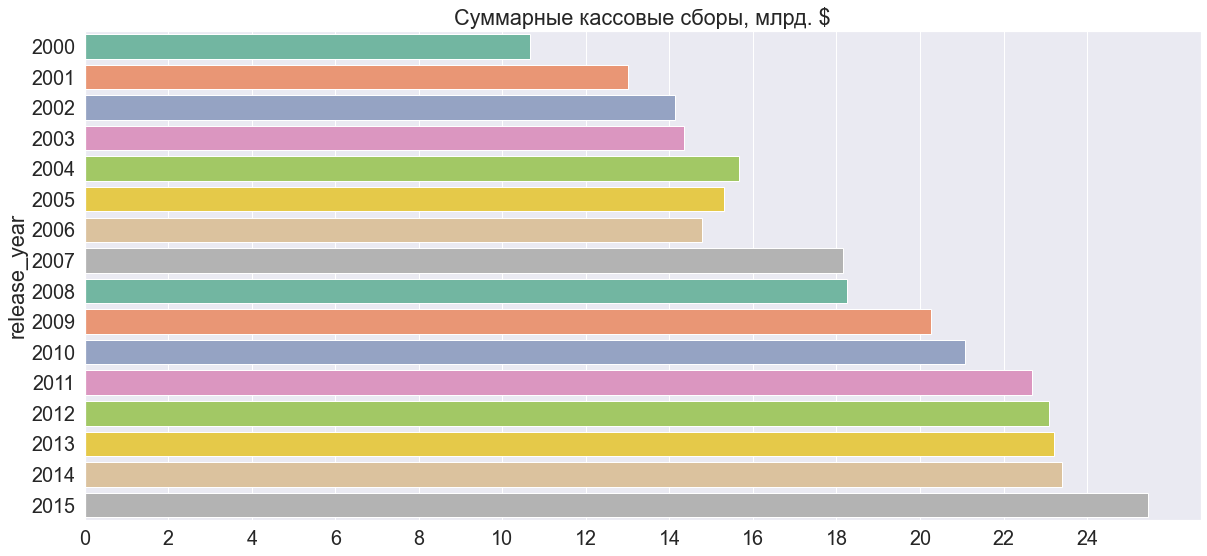

In [227]:
data.groupby('release_year')['revenue'].sum().sort_values(ascending=False)

sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 9))
plt.xticks(ticks = range(0,25,2))
plt.title('Суммарные кассовые сборы, млрд. $')
sns.color_palette("Set2")
sns.barplot(x=data.groupby('release_year')['revenue'].sum().sort_values(ascending=False).values/1000000000,
            y=data.groupby('release_year')['revenue'].sum().sort_values(ascending=False).index,
            palette='Set2', 
            orient='h')

In [42]:
answers['19'] = data.groupby('release_year')['revenue'].sum().idxmax()  

## 20. Какой самый прибыльный год для студии Warner Bros?

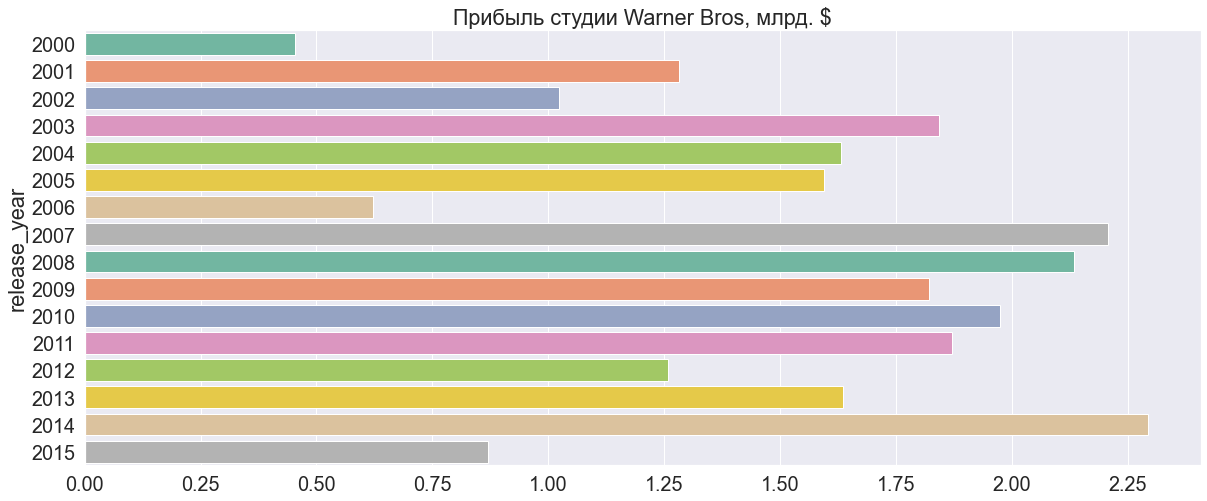

In [245]:
data_Warner = data_companies[data_companies['production_companies'].str.contains("Warner")]
data_Warner_profit = data_Warner.groupby(
    'release_year')['profit'].sum().sort_values(ascending=False).sort_index()

sns.set(font_scale=1.8)
plt.subplots(figsize=(20, 8))
plt.xticks(ticks=np.arange(0,2.5, 0.25))
plt.title('Прибыль студии Warner Bros, млрд. $')
sns.color_palette("Set2")
sns.barplot(x=data_Warner_profit.values/1000000000,
            y=data_Warner_profit.index,
            palette='Set2',
            orient='h')

In [44]:
answers['20'] = data_Warner.groupby('release_year')['profit'].sum().idxmax()

## 21. В каком месяце за все годы суммарно вышло больше всего фильмов?

In [45]:
data['month'].value_counts().sort_values(ascending=False)

September    227
December     190
October      186
August       161
March        156
April        149
June         147
November     146
July         142
May          140
February     135
January      110
Name: month, dtype: int64

In [46]:
answers['21'] = data['month'].value_counts().idxmax()  # "+"

## 22. Сколько суммарно вышло фильмов летом? (за июнь, июль, август)

In [47]:
data[((data['month'] == 'June')|
      (data['month'] == 'July')|
      (data['month'] == 'August'))]['imdb_id'].nunique()

450

In [48]:
answers['22'] = data[((data['month'] == 'June')|
                      (data['month'] == 'July')|
                      (data['month'] == 'August'))]['imdb_id'].nunique()  # "+"

## 23. Для какого режиссера зима – самое продуктивное время года? 

In [49]:
data_director[((data['month'] == 'December')|
               (data['month'] == 'January')|
               (data['month'] == 'February'))]['director'].value_counts()

<ipython-input-49-aa56e07c158e>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_director[((data['month'] == 'December')|


Peter Jackson        7
Clint Eastwood       6
Steven Soderbergh    6
Adam Shankman        4
Shawn Levy           4
                    ..
David R. Ellis       1
Mike Mitchell        1
Jessie Nelson        1
Seth Rogen           1
Joe Roth             1
Name: director, Length: 358, dtype: int64

In [50]:
answers['23'] = data_director[((data['month'] == 'December')|
                               (data['month'] == 'January')|
                               (data['month'] == 'February'))]['director'].value_counts().index[0]

<ipython-input-50-c0d1020768dc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  answers['23'] = data_director[((data['month'] == 'December')|


## 24. Какая студия дает самые длинные названия своим фильмам по количеству символов?

In [51]:
data_companies.groupby(['production_companies'])['len_title'].mean().sort_values(ascending=False)

production_companies
Four By Two Productions       83.0
Jim Henson Company, The       59.0
Dos Corazones                 47.0
Museum Canada Productions     46.0
Polsky Films                  46.0
                              ... 
Everest Entertainment          3.0
Berlanti Productions           3.0
XM2 Productions                2.0
Ixtlan Productions             2.0
Global Entertainment Group     2.0
Name: len_title, Length: 1771, dtype: float64

In [52]:
answers['24'] = data_companies.groupby(['production_companies'])['len_title'].mean().idxmax()

## 25. Описание фильмов какой студии в среднем самые длинные по количеству слов?

In [53]:
data_companies.groupby(['production_companies'])['words_in_overview'].mean().sort_values(ascending=False)

production_companies
Midnight Picture Show                    175.0
Room 9 Entertainment                     161.0
Heineken Branded Entertainment           161.0
98 MPH Productions                       159.0
Brookwell-McNamara Entertainment         156.0
                                         ...  
London Boulevard                          13.0
Phantom Four                              13.0
Henceforth                                13.0
Empire Pictures                           11.0
Motion Picture Corporation of America     11.0
Name: words_in_overview, Length: 1771, dtype: float64

In [54]:
answers['25'] = data_companies.groupby(['production_companies'])['words_in_overview'].mean().idxmax()

## 26. Какие фильмы входят в 1 процент лучших по рейтингу? 


In [55]:
data[data['vote_average'] > data['vote_average'].quantile(0.99)]['original_title']

9                                          Inside Out
34                                               Room
118                                      Interstellar
119                           Guardians of the Galaxy
125                                The Imitation Game
128                                         Gone Girl
138                          The Grand Budapest Hotel
370                                         Inception
599                                   The Dark Knight
872                                       The Pianist
1081    The Lord of the Rings: The Return of the King
1183                          The Wolf of Wall Street
1191                                 12 Years a Slave
1800                                          Memento
Name: original_title, dtype: object

In [56]:
answers['26'] = data[data['vote_average'] > data['vote_average'].quantile(0.99)]['original_title']

## 27. Какие актеры чаще всего снимаются в одном фильме вместе?


In [57]:
data['pairs'] = data['cast'].apply(lambda x: list(combinations(x,2)))
data_pairs = data.explode('pairs')
Counter(data_pairs['pairs']).most_common(1)

[(('Daniel Radcliffe', 'Rupert Grint'), 8)]

In [58]:
answers['27'] = Counter(data_pairs['pairs']).most_common(1)[0][0]

# Submission

In [59]:
answers  # в конце можно посмотреть свои ответы к каждому вопросу

{'1': 'Pirates of the Caribbean: On Stranger Tides',
 '2': 'Gods and Generals',
 '3': 'Winnie the Pooh',
 '4': 109.6585494970884,
 '5': 107.0,
 '6': 'Avatar',
 '7': 'The Lone Ranger',
 '8': 1478,
 '9': 'The Dark Knight',
 '10': 'The Lone Ranger',
 '11': 'Drama',
 '12': 'Drama',
 '13': 'Peter Jackson',
 '14': 'Robert Rodriguez',
 '15': 'Chris Hemsworth',
 '16': 'Matt Damon',
 '17': 'Action',
 '18': 'K-19: The Widowmaker',
 '19': 2015,
 '20': 2014,
 '21': 'September',
 '22': 450,
 '23': 'Peter Jackson',
 '24': 'Four By Two Productions',
 '25': 'Midnight Picture Show',
 '26': 9                                          Inside Out
 34                                               Room
 118                                      Interstellar
 119                           Guardians of the Galaxy
 125                                The Imitation Game
 128                                         Gone Girl
 138                          The Grand Budapest Hotel
 370                                

In [60]:
len(answers)  # и убедиться что ни чего не пропустил)

27